In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [56]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [57]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [58]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [59]:
series = pd.read_csv('/Users/pranshu/Documents/Work/Datasets/city_day.csv')
series_delhi = series.loc[series['City'] == 'Delhi']
ts_delhi = series_delhi[['Date','AQI']]
#converting 'Date' column to type 'datetime' so that indexing can happen later
ts_delhi['Date'] = pd.to_datetime(ts_delhi['Date'])

In [60]:
ts_delhi['Date'].min(), ts_delhi['Date'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2020-05-01 00:00:00'))

In [61]:
ts_delhi.isnull().sum()
ts_delhi = ts_delhi.dropna()
ts_delhi.isnull().sum()

Date    0
AQI     0
dtype: int64

In [62]:
ts_delhi = ts_delhi.set_index('Date')

In [63]:
ts_month_avg = ts_delhi['AQI'].resample('MS').mean()

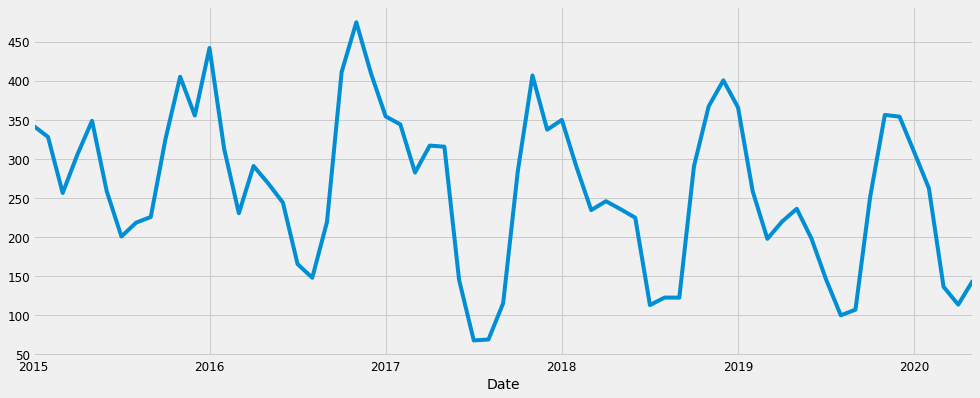

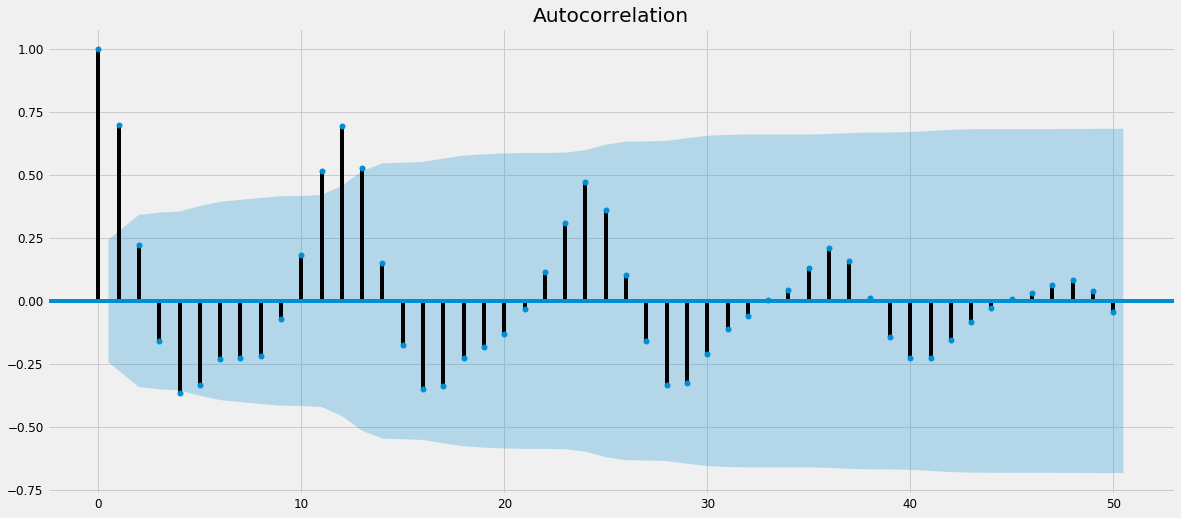

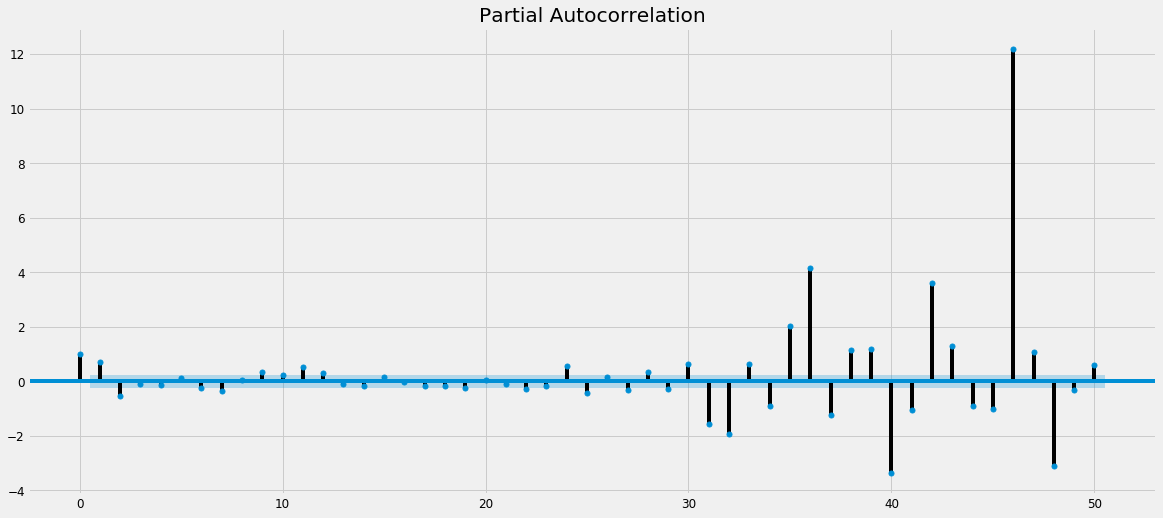

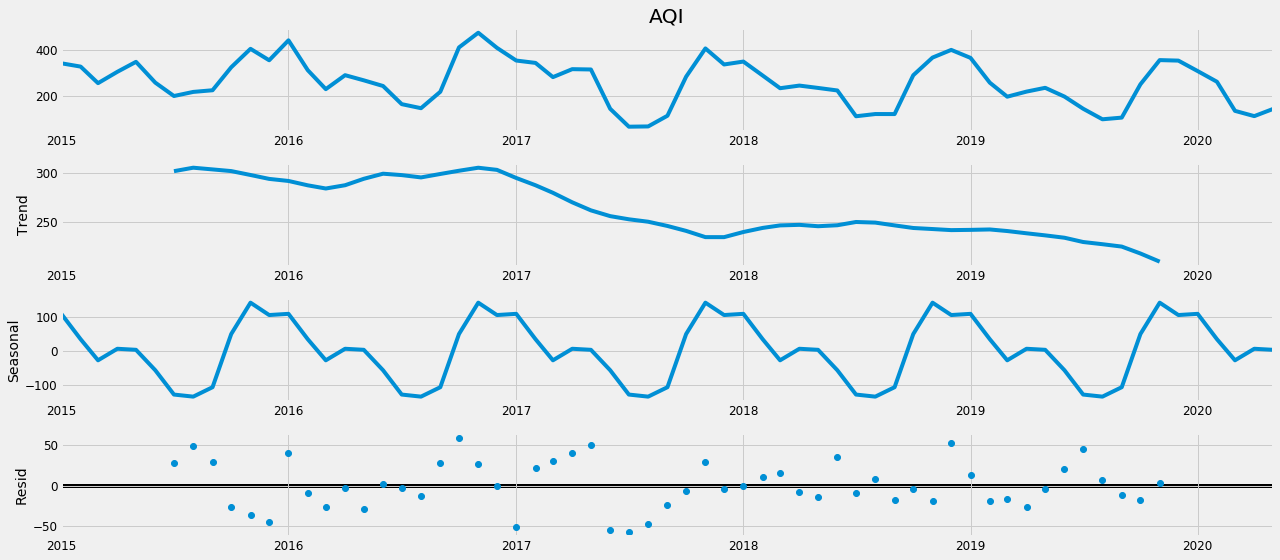

In [64]:
ts_month_avg.plot(figsize=(15, 6))
plt.show()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_month_avg, lags=50)
matplotlib.pyplot.show()
plot_pacf(ts_month_avg, lags=50)
matplotlib.pyplot.show()

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ts_month_avg, model='additive')
fig = decomposition.plot()
plt.show()

In [65]:
#apply adf test on the series
print(adf_test(ts_month_avg))
print(kpss_test(ts_month_avg))

Results of Dickey-Fuller Test:
Test Statistic                  0.041809
p-value                         0.961856
#Lags Used                     11.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64
None
Results of KPSS Test:
Test Statistic            0.612726
p-value                   0.021479
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None


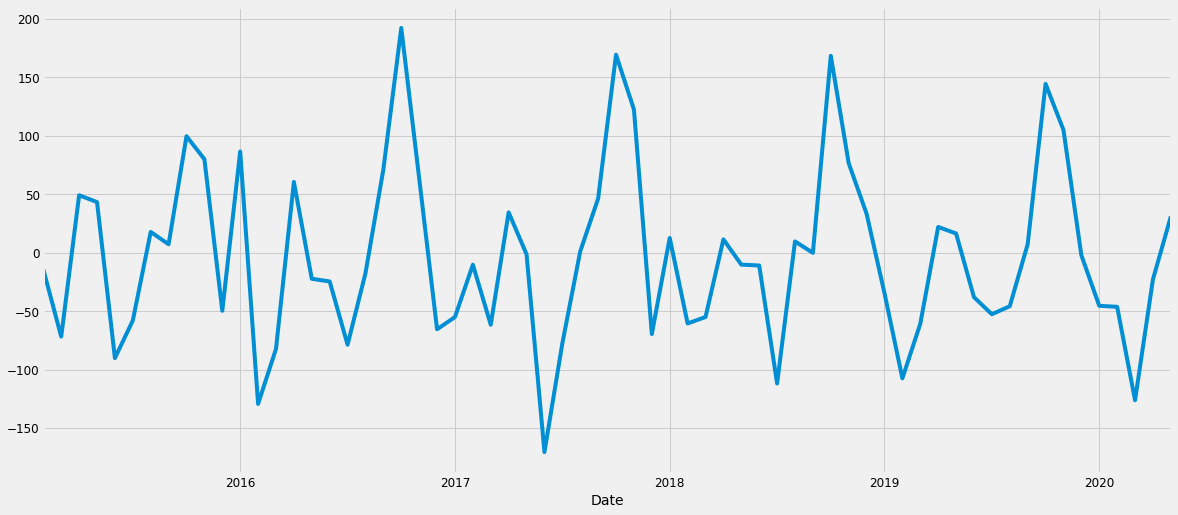

In [66]:
ts_t_adj = ts_month_avg - ts_month_avg.shift(1)
ts_t_adj = ts_t_adj.dropna()
ts_t_adj.plot()

In [67]:
#apply adf test on the series
print(adf_test(ts_t_adj))

Results of Dickey-Fuller Test:
Test Statistic                -6.654613e+00
p-value                        5.020683e-09
#Lags Used                     1.000000e+01
Number of Observations Used    5.300000e+01
Critical Value (1%)           -3.560242e+00
Critical Value (5%)           -2.917850e+00
Critical Value (10%)          -2.596796e+00
dtype: float64
None


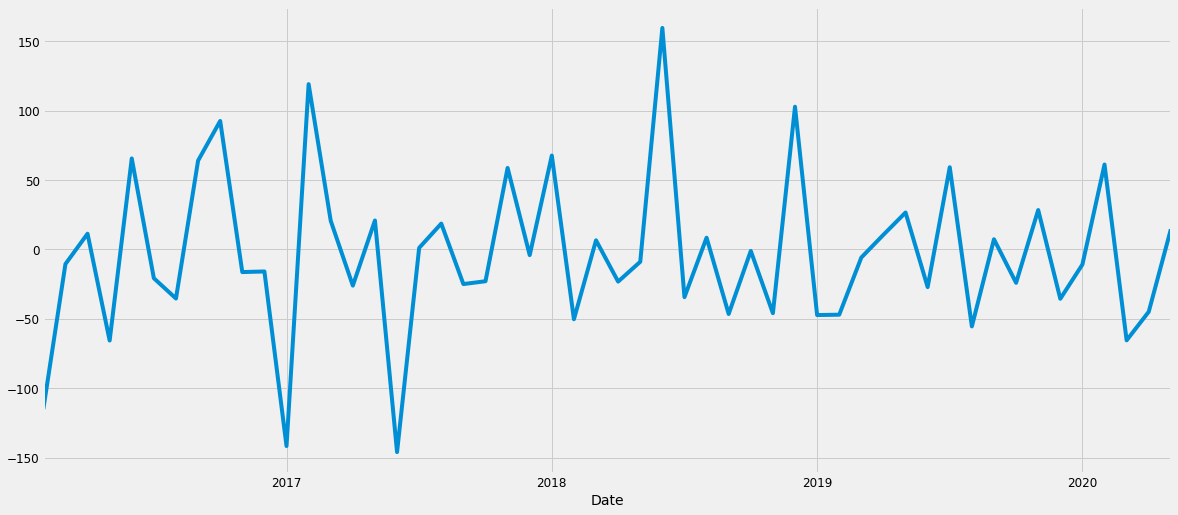

In [68]:
ts_s_adj = ts_t_adj - ts_t_adj.shift(12)
ts_s_adj = ts_s_adj.dropna()
ts_s_adj.plot()

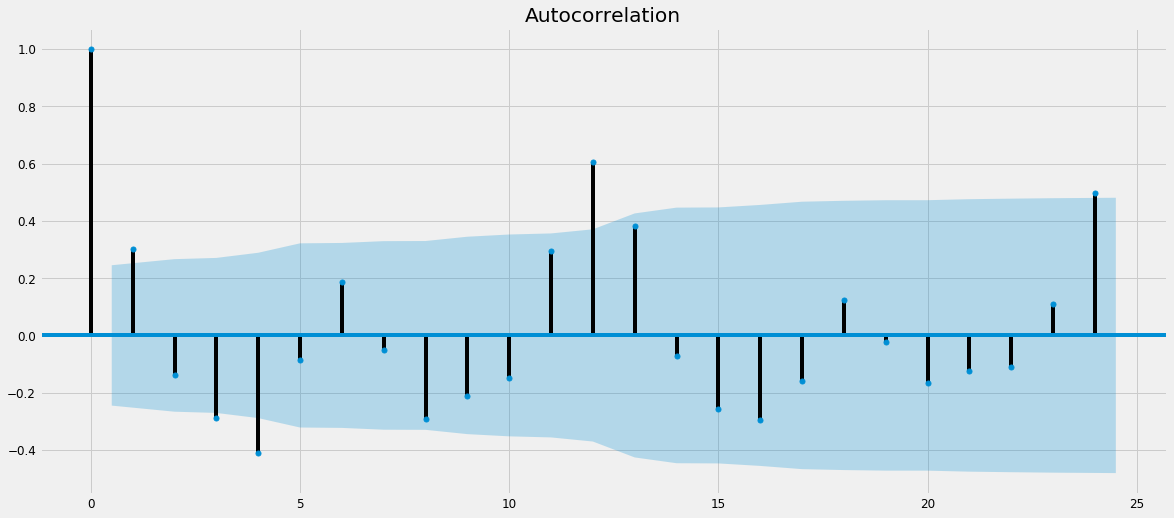

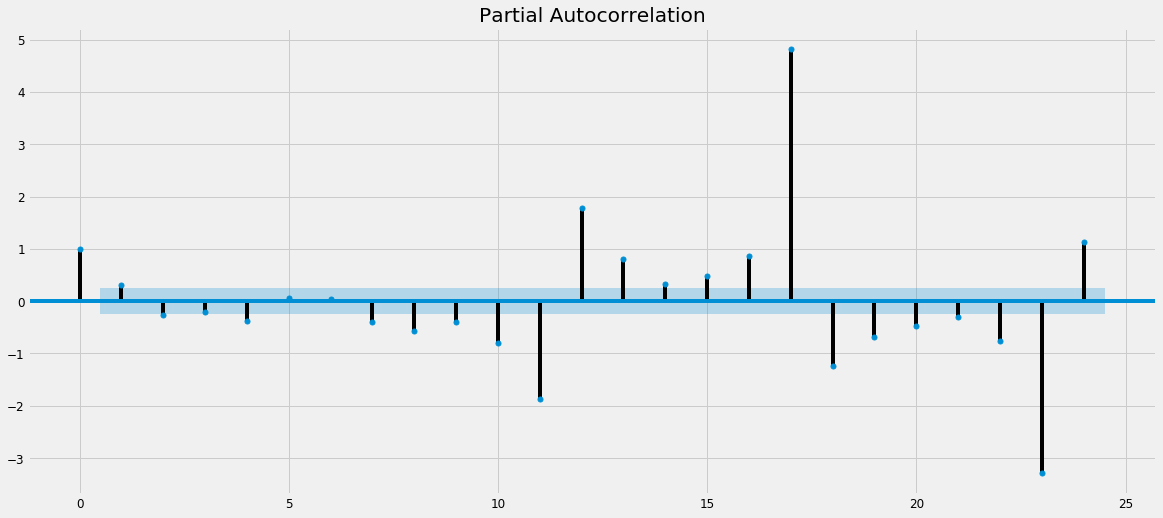

In [83]:
# Plotting the ACF and PACF Plot of the Trend and Seasonally adjusted Time Series data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_t_adj, lags=24)
matplotlib.pyplot.show()
plot_pacf(ts_t_adj, lags = 24)
matplotlib.pyplot.show()

In [99]:
p = range(0, 3)
d = range(1,2)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
seasonal_pdq

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (0, 1, 3, 12)


[(0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 1, 3, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 1, 3, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 1, 3, 12)]

In [100]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_s_adj,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            )
            results = mod.fit(method = 'powell')
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Optimization terminated successfully.
         Current function value: 4.915992
         Iterations: 2
         Function evaluations: 42
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:513.2631696187234
Optimization terminated successfully.
         Current function value: 4.696279
         Iterations: 2
         Function evaluations: 154
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:492.41299164660177
Optimization terminated successfully.
         Current function value: 4.569954
         Iterations: 6
         Function evaluations: 235
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:481.2752427974604
Optimization terminated successfully.
         Current function value: 4.514433
         Iterations: 6
         Function evaluations: 321
ARIMA(0, 1, 0)x(0, 1, 3, 12)12 - AIC:477.5009962313355
Optimization terminated successfully.
         Current function value: 4.642192
         Iterations: 2
         Function evaluations: 54
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:486.78801325163585
Optimization terminated successfull

In [101]:
#ARIMA(0, 1, 1)x(2, 1, 0, 12)
mod = sm.tsa.statespace.SARIMAX(ts_s_adj,
                                order=(0, 1, 1),
                                seasonal_order=(2, 1, 0, 12))
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 4.299277
         Iterations: 5
         Function evaluations: 301
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      0.424     -2.359      0.018      -1.831      -0.169
ar.S.L12      -1.2291      0.176     -6.991      0.000      -1.574      -0.884
ar.S.L24      -0.6744      0.156     -4.321      0.000      -0.980      -0.369
sigma2      2697.9323      0.000   1.72e+07      0.000    2697.932    2697.933


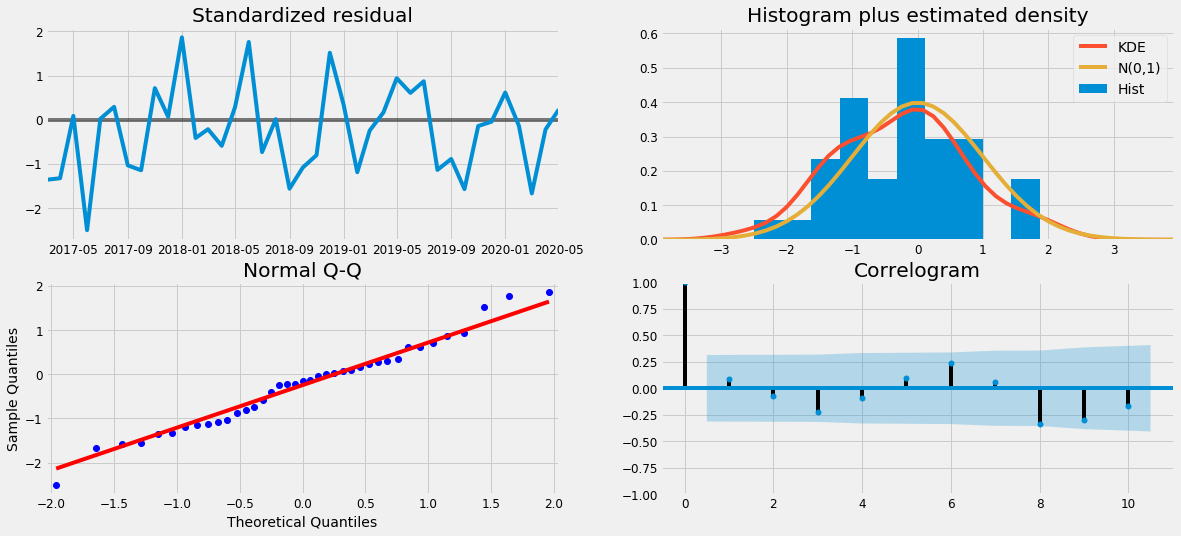

In [102]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

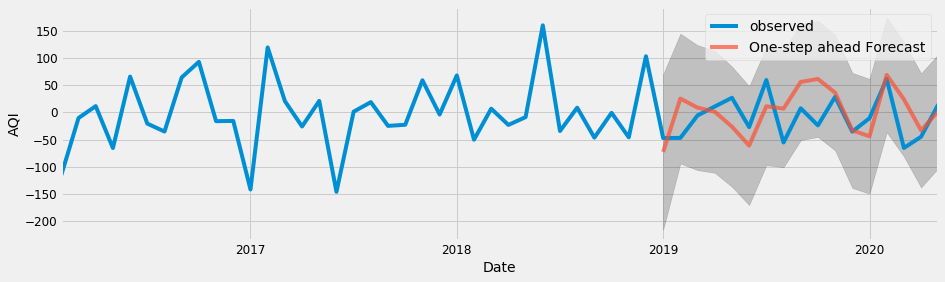

In [103]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts_s_adj.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

In [104]:
y_forecasted = pred.predicted_mean
y_truth = ts_s_adj['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 2083.03
The Root Mean Squared Error is 45.64
